In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

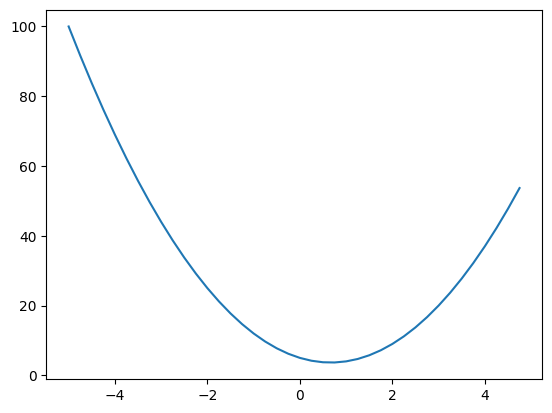

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, label='f(x)')

In [5]:
h = 0.0001

# input

a = -5.0
b = 7.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope' , (d2 - d1) / h)

d1 -25.0
d2 -25.000500000000002
slope -5.000000000023874


In [20]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # effect on the loss
        self._backward = lambda: None
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), 
                     '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
        
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"



In [7]:
a = Value(2.0)
b = Value(8.0)
b - a

Value(data=6.0, grad=0.0)

In [8]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [9]:
draw_dot(L)

NameError: name 'L' is not defined

In [ ]:
def lol():
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e =  a * b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e =  a * b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')    
    print(d, f)
    L = d * f; L.label = 'L'
    L2 = L.data
    
    
    print((L2 - L1) / h)

lol()

Value(data=4.0) Value(data=-1.999)
3.9999999999995595


In [ ]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0
# L = d * f
# dL / dd = f

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad


e = a * b
d = e + c
L = d * f


print(L.data)

-6.586368000000001


In [ ]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813558889989898, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()

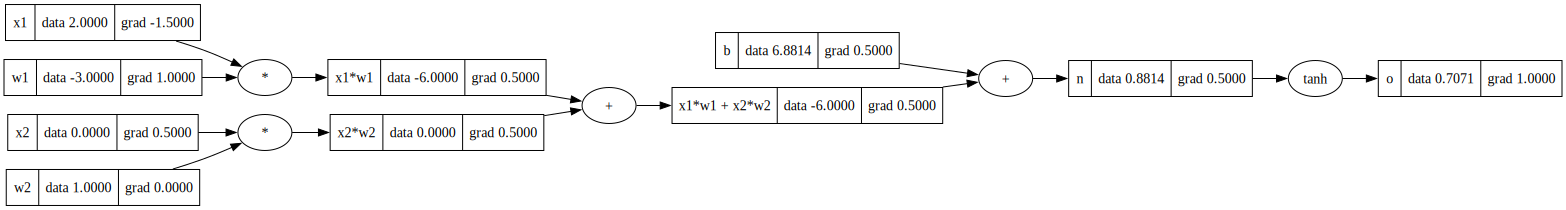

In [ ]:
draw_dot(o)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813558889989898, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# -----
e = (2*n).exp()
o = (e - 1) / (e + 1) 
o.label = "o"
# -----
o.backward()

NameError: name 'Value' is not defined

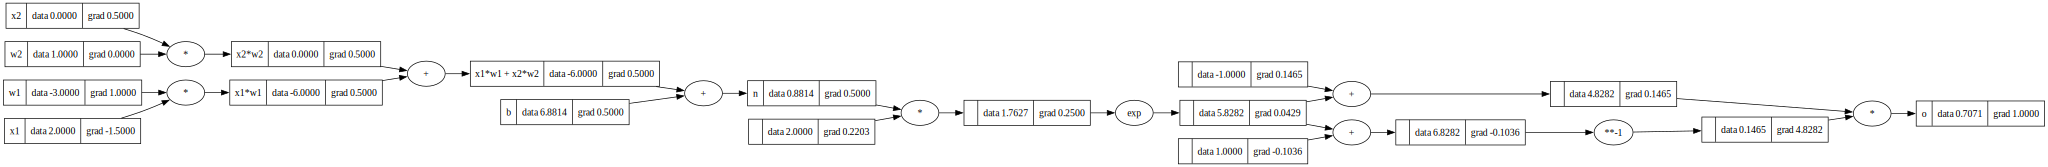

In [ ]:
draw_dot(o)

In [ ]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [ ]:
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [ ]:
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [ ]:
# x1w1.grad = 0.5
# x2w2.grad = 0.5

In [ ]:
# x1w1x2w2.grad = 0.5
# b.grad = 0.5

In [ ]:
# n.grad = 0.5

In [ ]:
# o.grad = 1.0

In [ ]:
# do / dn = 1 - tanh(2)**2


In [21]:
import random

class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

class Layer():
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"
        

class Neuron():
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"
    


In [22]:
x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.7711656099793888, grad=0.0)

In [23]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [24]:
for k in range(50):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # zero grad
    for p in n.parameters():
       p.grad = 0
    
    # backward pass:
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 8.196534540843304
1 4.602979274558216
2 2.3668698565118222
3 1.4744227394989644
4 0.9167907844646654
5 0.6180278229466449
6 0.4467466745889883
7 0.3404444624482113
8 0.270077746750516
9 0.22103078332159806
10 0.18538526097271246
11 0.15858106898541427
12 0.13785015556648772
13 0.12143517219328237
14 0.1081768815963563
15 0.09728503734364308
16 0.0882054021965595
17 0.08053951985422425
18 0.07399463867384058
19 0.06835150279700904
20 0.06344307609264718
21 0.05914014979424201
22 0.05534139684323936
23 0.05196636571982867
24 0.0489504583636569
25 0.04624127291207901
26 0.043795901616965976
27 0.04157890789337246
28 0.03956079328457508
29 0.03771682259893956
30 0.03602611415373609
31 0.03447092849910885
32 0.03303610732702787
33 0.03170862715122262
34 0.030477241508398097
35 0.02933219202694122
36 0.02826497350843105
37 0.02726814169470823
38 0.026335155010903243
39 0.025460243534858262
40 0.02463829992350539
41 0.02386478815347317
42 0.02313566679738531
43 0.02244732422492897
44 0.0217

In [25]:
n.layers[0].neurons[0].w[0]

Value(data=0.04319261943589534, grad=-0.004158191243865371)

In [26]:
ypred

[Value(data=0.9564468364693515, grad=-0.08710632706129706),
 Value(data=-0.933798665527208, grad=0.13240266894558395),
 Value(data=-0.9287075229114291, grad=0.1425849541771418),
 Value(data=0.9125293126234879, grad=-0.17494137475302418)]

In [27]:
n.parameters()

[Value(data=0.04319261943589534, grad=-0.004158191243865371),
 Value(data=-0.4657262365193655, grad=0.004790246736006978),
 Value(data=0.7437494341418935, grad=-0.021120031393324714),
 Value(data=0.24586184166118324, grad=-0.0021721362376431446),
 Value(data=0.013895885255380177, grad=-0.011263660613112386),
 Value(data=0.7604055252090333, grad=-0.011170291260087832),
 Value(data=-0.2970167401963535, grad=0.025049863017020925),
 Value(data=-0.9073338509232028, grad=-0.009265047190666474),
 Value(data=0.6971336810074301, grad=0.001819463430247537),
 Value(data=-0.20729488266925156, grad=0.0016212340987272736),
 Value(data=-0.3262998534501784, grad=-0.0017777436860538856),
 Value(data=-0.10267610826238739, grad=0.0018425203538457563),
 Value(data=-1.1098242220387866, grad=0.0006022092766046138),
 Value(data=0.41494351059626144, grad=-0.002207035605072815),
 Value(data=0.31042642862961267, grad=-0.0100073274041506),
 Value(data=0.06064945728050833, grad=-0.002869131776564915),
 Value(data

In [28]:
draw_dot(n)

AttributeError: 'MLP' object has no attribute '_prev'